<a href="https://colab.research.google.com/github/jermwatt/meme_search/blob/main/meme_search_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# if running in collab pull repo and install requirements
if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/jermwatt/meme_search.git
    %cd meme_search_walkthrough
    !pip install -r requirements.txt

# lets build a meme search engine

- meme warefare is a perpetual way of life these days.

- i have a big folder of my most prized memes.  sits on my desktop.  most are screenshots and have randon manes.

- my OS doesn't provide good searchability of these images. 

- so i'm forced to arrow through them whenever i need to find a good one.

- i want to be able to search through my memes faster - semantically via their text or visual content.

--- 

- so lets make a completely local meme search engine.

- the end product will be a streamlit app that lets us quickly search through our meme collection semantically.  see the `README.md` of this repo if you want to skip this walkthrough and play with it now.

---

- how do we create the foundation of the search engine?

- we want each image is indexed based on both its text (the text laid over the image) and a text description of its visual content.  and we want to make that text searchable.

- here's how we'll do it in 5 steps:

1.  extract text descriptions of each image, including ocr of any text on the image, using the kickass tiny vision-llm  [moondream](https://github.com/vikhyat/moondream)
2.  window each image's text description, producing a list of text chunks per image
3.  embed those chunks using a popular embedding model - [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
4.  store and index the embeddings in an open source and local vector base [faiss database](https://github.com/facebookresearch/faiss)
5.  store references connecting the embeddings to their images in the greatest little db of all time - [sqlite](https://sqlite.org/), which comes builtin with python

- here's the collection of 8 meme's we'll use for testing.

- lets roll.


<style>
    #images {
    white-space: nowrap;
}
</style>
<div style="border: thin solid black">
<img src="./data/input/all_guitars.jpg" width="25%">
<img src="./data/input/aw60d6V6_700w_0.jpg" width="25%">
<img src="./data/input/great_song.jpg" width="25%">
<img src="./data/input/real_men.jpg" width="25%">
<img src="./data/input/test_meme_1.jpg" width="25%">
<img src="./data/input/test_meme_2.jpg" width="25%">
<img src="./data/input/test_meme_3.jpg" width="25%">
<img src="./data/input/weird_knowledge.jpg" width="25%">
</div>

</ul>


# 1.  extract text descriptions from images using a vlm

- a vision language model (vlm) takes in an image and text prompt, and outputs text

- they're used as baseline caption models often but - depending on how their trained / fine tuned - can be used for [other things as well]([larger list here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard)).  things like
    - question answering: asking questions about an image
    - optical character recognition (ocr): find text in an image
    - general object detection
    - ...

- we will [moondream](https://github.com/vikhyat/moondream), very powerful yet tiny model you can run locally.

- if you have decent hardware you can easily swap moondream out for a larger model of your choosing - like a [larger model similarly trained](https://github.com/clovaai/donut), or one fine tuned for particular task like ocr - see e.g., [kosmos](https://github.com/microsoft/unilm/tree/master/kosmos-2.5)

- below we use a lightly modified version of the basic moondream setup you can find on their repo.

- the function `prompt_moondream` takes in a path to an image and an input prompt, and returns the "answer" from the model.

- you can see we will use several libraries here like PIL and transformers - you can install everything you need here using the `requirements.txt` of this repo

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import transformers
transformers.logging.set_verbosity_error()


def prompt_moondream(img_path: str, prompt: str) -> str:
    # copied from moondream demo readme --> https://github.com/vikhyat/moondream/tree/main
    model_id = "vikhyatk/moondream2"
    revision = "2024-05-20"
    model = AutoModelForCausalLM.from_pretrained(
        model_id, trust_remote_code=True, revision=revision,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
    image = Image.open(img_path)
    enc_image = model.encode_image(image)
    moondream_response = model.answer_question(enc_image, prompt, tokenizer)
    return moondream_response

/Users/jeremywatt/Desktop/content_creation/meme_search/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- lets explore two prompts for getting detailed text descriptions of our memes

- the baseline prompt for captioning images with moondream is "Describe this image."

- we use this and process each of our images, showing the results below (using matplotlib).

- moondream's baseline "caption" prompt does a great job of providing both an accurate description of the content of the image, as well as "ocr"-ing the text laid on top of it.

In [2]:
# load in images from data/input/
import os
file_src = "data/input/"
img_paths = []
for x in os.listdir(file_src):
    if x.split(".")[-1] in ["jpg", "jpeg", "png"]:
        img_paths.append("data/input/" + x)

# extract description of each image
prompt = "Describe this image."
answers = [prompt_moondream(img_path, prompt) for img_path in img_paths]

NameError: name 'prompt_moondream' is not defined

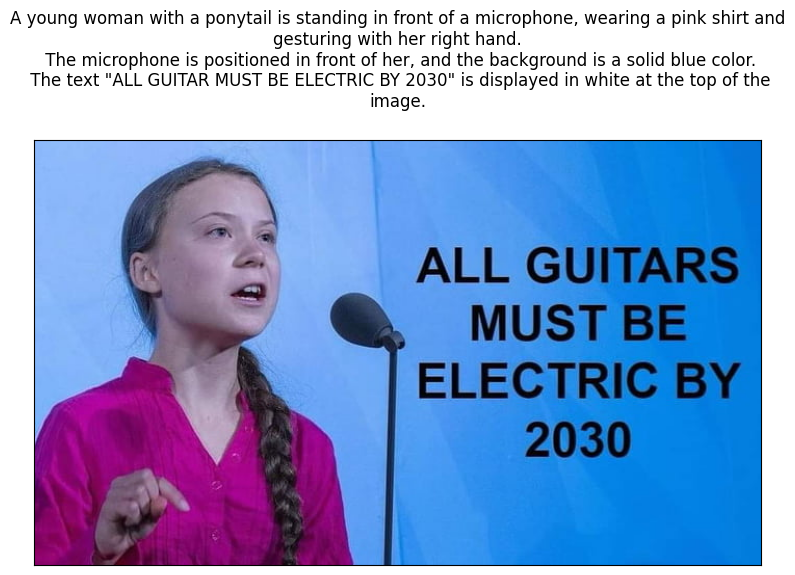

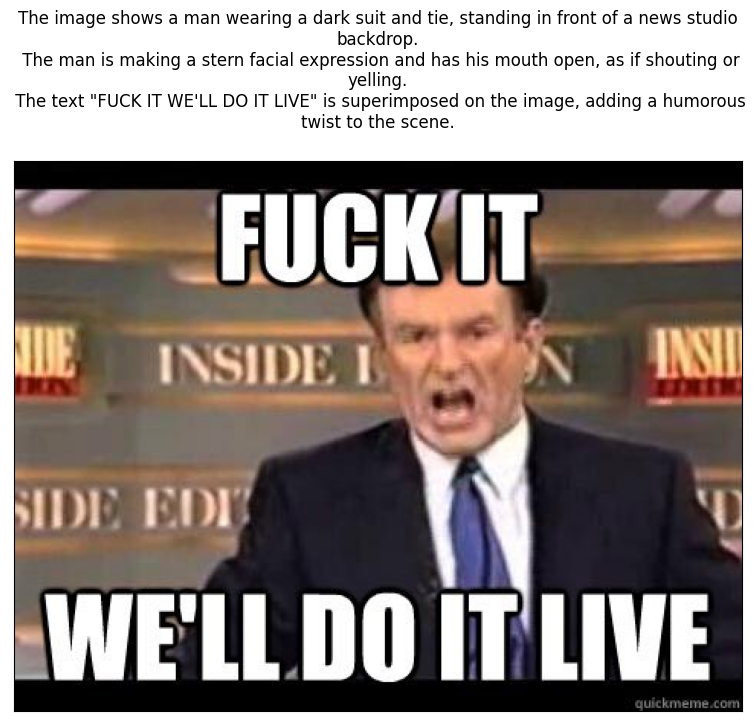

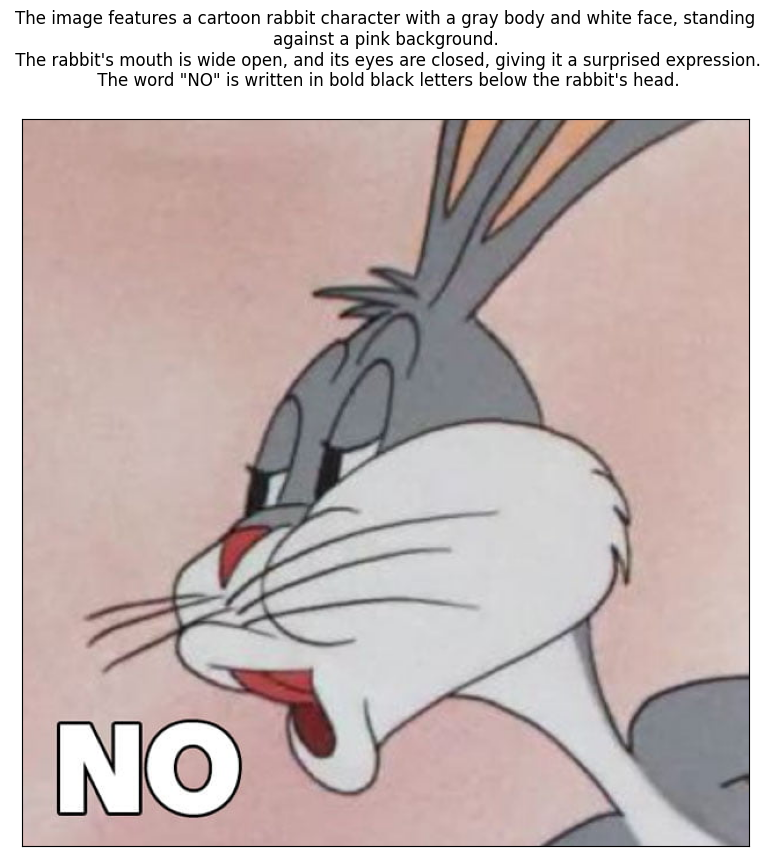

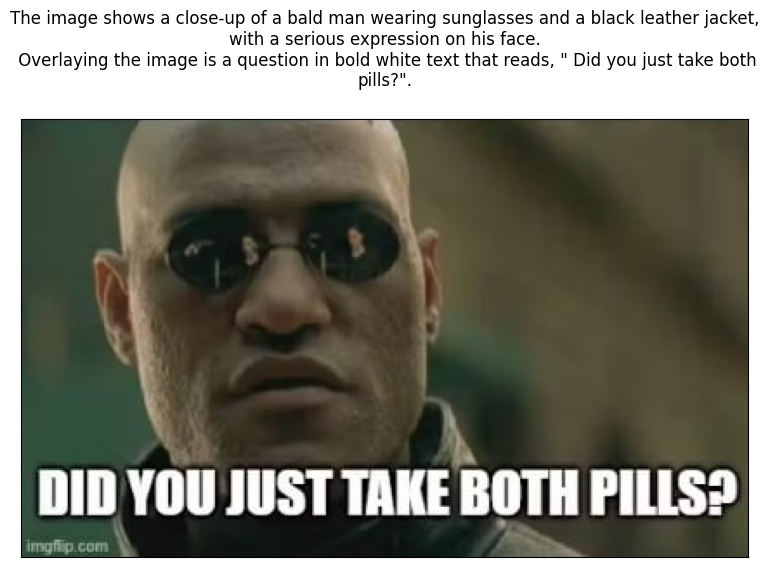

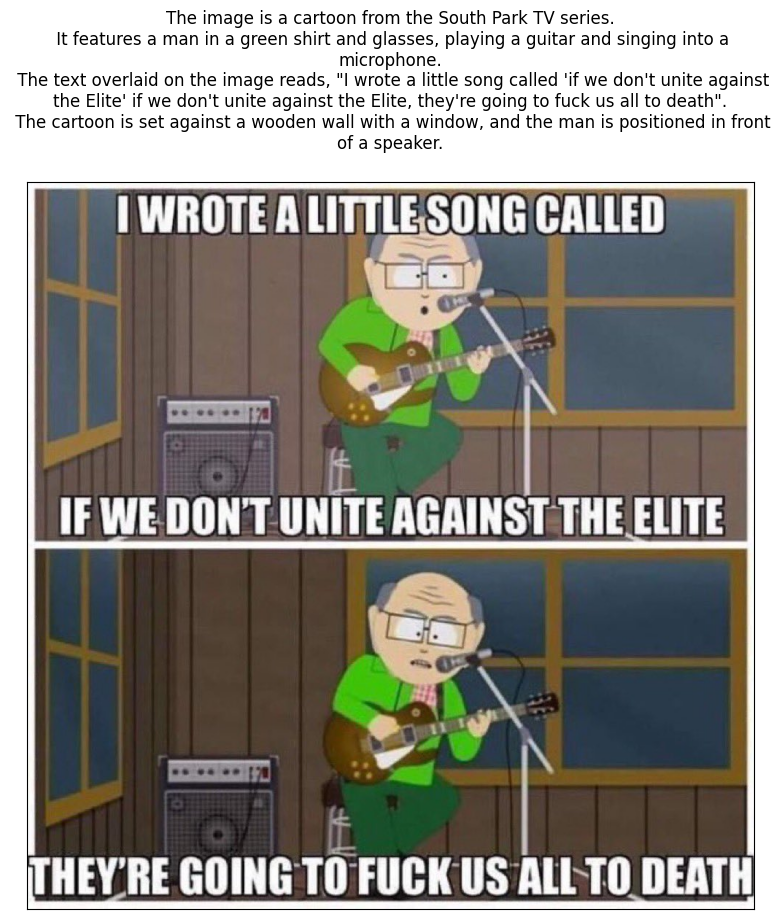

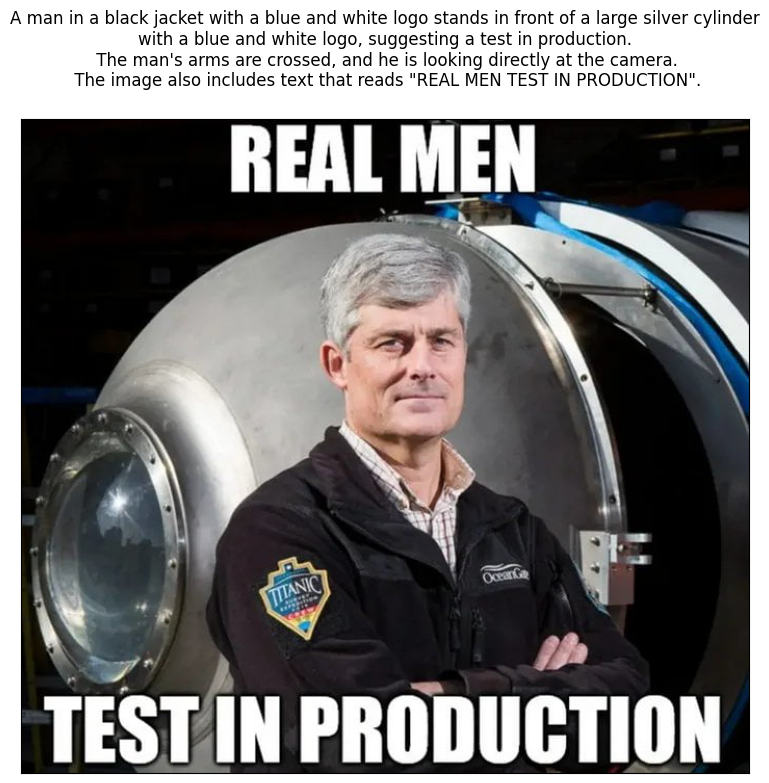

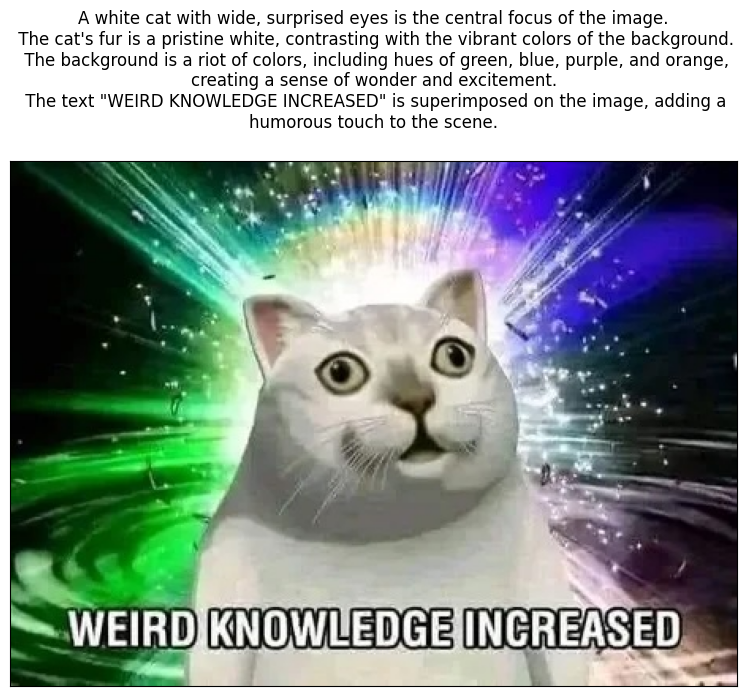

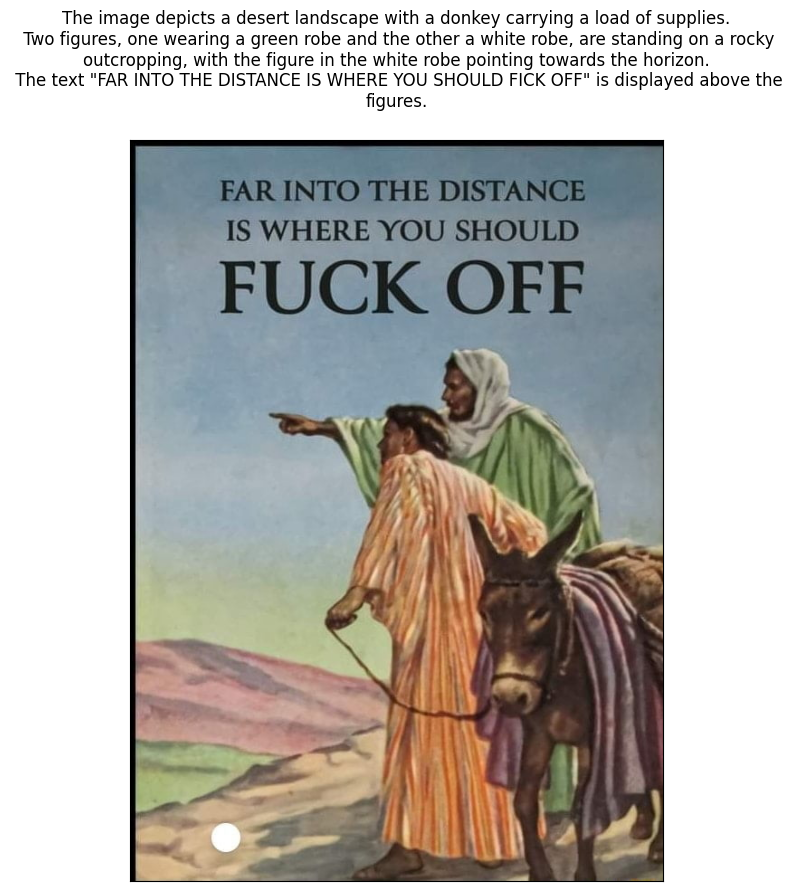

In [7]:
import matplotlib.pyplot as plt

for ind in range(len(img_paths)):
    img_path = img_paths[ind]
    img = Image.open(img_path)
    ans = answers[ind]
    ans = '.\n'.join(ans.split('.'))
    fig, sub = plt.subplots(nrows=1, ncols=1, figsize=(5, 5));
    fig.tight_layout(); 

    sub.imshow(img)
    sub.set_xticks([]);
    sub.set_yticks([]);
    sub.set_title(ans, wrap=True, ha='center',va="bottom")


- side note: if we wanted to just pluck out the text of the memes, the prompt below seems to work fairly well with moondream.

```python
prompt = "What does the text on this image say?  Return only the text you find."
```

## how to make a meme's text description semantically searchable

- we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description
- to maximize flexibility in recall we will use a vector search approach
- for each meme text descriptor output from moondream we will
    - chunk the text using a (slightly adjusted version of a) standard sliding window approach
    - embed each chunk using a text embedding model
    - dump each into a vector database
- once complete we will then index the vector database for quick querying

---

- we begin by looking at how to make a single image's text description semantically ("vector") searchable
- first the fixed chunking - here we use a simple two-pointers approach to slicing up an input text into overlapping chunks
- we'll fix the chunk and overlap sizes to 4 and 2 respectively - since we imagine recalling meme images by only a few words at query time
- our slight adjustment: since we might want to search via the meme's text in its entirety (they'll all likely be pretty short) we will include the full text of the meme as well

In [6]:
import re
def clean_word(text: str) -> str:
    # clean input text - keeping only lower case letters, numbers, punctuation, and single quote symbols
    return re.sub(" +", " ", re.compile("[^a-z0-9,.!?']").sub(" ", text.lower().strip()))

def chunk_text(text: str) -> list:
    # split and clean input text
    text_split = clean_word(text).split(" ")
    text_split = [v for v in text_split if len(v) > 0]

    # use two pointers to create chunks
    chunk_size = 4
    overlap_size = 2

    # create next chunk by moving right pointer until chunk_size is reached or line_number changes by more than 1 or end of word_sequence is reached
    left_pointer = 0
    right_pointer = chunk_size - 1
    chunks = []

    if right_pointer >= len(text_split):
        chunks = [" ".join(text_split)]
    else:
        while right_pointer < len(text_split):
            # check if chunk_size has been reached
            # create chunk
            chunk = text_split[left_pointer:right_pointer+1]
            
            # move left pointer
            left_pointer += chunk_size - overlap_size

            # move right pointer
            right_pointer += chunk_size - overlap_size

            # store chunk
            chunks.append(" ".join(chunk))
        
        # check if there is final chunk
        if len(text_split[left_pointer:]) > 0:
            last_chunk = text_split[left_pointer:]
            chunks.append(" ".join(last_chunk))
    
    # insert the full text
    if len(chunks) > 1:
        chunks.insert(0,text.lower())
    return chunks

In [165]:
# a small test of our chunking algorithm
text = "we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description"
chunks = chunk_text(text)
for chunk in chunks:
    print(chunk)

we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description
we can use moondream's
use moondream's respnose to
respnose to either prompt,
either prompt, or both,
or both, to help
to help us organize
us organize and easily
and easily recall a
recall a meme based
meme based on an
on an input text
input text description


- now we use a text embedding model to transform each chunk into a vector
- we will use the popular [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model here
- this transforms each input chunk into a dense vector of length 384 (which is defined by the embedding model)
- below we transform the example chunks above

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def encode_chunks(chunks: list) -> np.ndarray:
    return model.encode(chunks)

In [167]:
# test our simple embedding function by embedding chunks above
embeddings = encode_chunks(chunks)
print(embeddings.shape)

(13, 384)


- we can now dump embeddings into a vector db
- we will use the open source [faiss database](https://github.com/facebookresearch/faiss)

In [168]:
import numpy as np
import faiss

def create_vector_db(db_file_path: str,
                     embeddings: np.ndarray) -> None:
    # dump all_embeddings to faiss index
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)

    # write index to disk
    faiss.write_index(index, db_file_path)

In [169]:
# test create_vector_db by dumping embeddings and indexing
create_vector_db("test.faiss", embeddings)

- lets try a test query on our newly minted vector db
- to do this we take an input query in text form and embed it using the same embedder model we used to create the items of the database
- as an example query we'll use a substring of the original input - "either prompt, or both, to help"
- this will likewise create a dense vector of length 384 (defined by the embedding model)
- notice the query return contains two items: `distances` and `indices`
- `distances` contains an array of distances in ascending order
- `indices` contains an array of integer values ordered according to their respective `distances`, from those closest to our input query to those most different from it, and represent the indices of our initial input (`chunks`) above

In [170]:
import faiss
import numpy as np
from typing import Tuple

def query_vector_db(query: str,
                    db_file_path: str,
                    k: int=5) -> Tuple[list,list]:
    # connect to db
    faiss_index = faiss.read_index(db_file_path)

    # test
    encoded_query = np.expand_dims(model.encode(query), axis=0)

    # query db
    distances, indices = faiss_index.search(encoded_query, k)
    distances=distances.tolist()[0]
    indices=indices.tolist()[0]
    return distances, indices

In [171]:
# map indices back to our initial chunks and print top 5 closest datapoints from chunks
query = "either prompt, or both, to help"
distances, indices = query_vector_db(query, "test.faiss")
query_closest = [chunks[i] for i in indices]
print(f"example_query = '{query}'")
for ind, chunk in enumerate(query_closest):
    print(f"chunk '{chunk}' has distance {round(distances[ind],2)} from example query")

example_query = 'either prompt, or both, to help'
chunk 'either prompt, or both,' has distance 0.18 from example query
chunk 'respnose to either prompt,' has distance 0.39 from example query
chunk 'or both, to help' has distance 1.14 from example query
chunk 'we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description' has distance 1.14 from example query
chunk 'input text description' has distance 1.24 from example query


## making our memes semantically searchable

- now that we know how to make a single meme's text descriptor semantically searchable we can do so for each image in our dataset
- any future query can then be easily adapated to return the name of the closest images whose text descriptors most align with the input query
- to do this we only need to
    - process each meme's text descriptor by chunking
    - slightly adjust our `chunks` array to also contain the name of the image for each chunk
    - embed each chunk
    - dump all embeddings into the vector db
    - done
- let's take care of the first two items first
- we will loop through our meme's text descriptor - here we will use the result of our second (text only) prompt response from moondream - and store each set of chunks with reference to its respective meme filepath
- because our set of images is so small we will just use a list of dictionaries as our database for this information
- even a setup this un-optimized will work just fine for a few thousand images at least
- nonetheless dumping this data into a sqlite table is recommended - its compact, speedy, there are great python bindings for it, and you're the only one who'll hit it with requests - a perfect use case
- we'll do this but leave it optional in the appendix

In [9]:
# loop over each meme's moondream based text descriptor and create a short dict containing its full and chunked text
def create_all_img_chunks(img_paths: list,
                          answers: list) -> list:
    img_chunks = []
    for ind, img_path in enumerate(img_paths):
        moondream_meme_text = answers[ind]
        moondream_chunks = chunk_text(moondream_meme_text)
        for chunk in moondream_chunks:
            entry = {}
            entry["img_path"] = img_path
            entry["chunk"] = chunk
            img_chunks.append(entry)
    return img_chunks

In [11]:
img_chunks = create_all_img_chunks(img_paths, answers_text_only)
for chunk in img_chunks:
    print(chunk)

{'img_path': 'data/input/fake.jpeg', 'chunk': 'a man with dark hair and a black hoodie is standing in front of a wall adorned with a collage of various images. the wall behind him is covered in a vibrant array of photographs and illustrations, creating a visually striking backdrop. the man is positioned in the center of the image, his gaze directed towards the viewer. the text "fake and or gay" is prominently displayed in large, bold letters above the man, suggesting a connection to the theme of the collage.'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'a man with dark'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'with dark hair and'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'hair and a black'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'a black hoodie is'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'hoodie is standing in'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'standing in front of'}
{'img_path': 'data/input/fake.jpeg', 'chunk': 'front of a wall'}
{'img_path':

- now only a slight adjustment to the remainder of the embedding / vector db functions above is required
- we feed in the chunks - stripped off each entry of this list of dictionaries
- then when querying we can map back to the proper entry

In [220]:
# embed all chunks
chunks = [v["chunk"] for v in img_chunks]
embeddings = encode_chunks(chunks)

# dump to db
create_vector_db("test.faiss", embeddings)

- now we can query this db, and use the closest matching indices to look up the proper image in `img_chunks`

In [221]:
# query our db
query = "you ate two capsules didn't you"
db_file_path = "test.faiss"
distances, indices = query_vector_db(query, db_file_path)

# map indices back to correct image in img_chunks
img_entries = [img_chunks[i] for i in indices]
for ind, entry in enumerate(img_entries):
    print((entry, f"distance = {round(distances[ind],2)})"))

({'img_path': 'data/input/test_meme_2.jpg', 'chunk': 'did you just take both pills?'}, 'distance = 0.76)')
({'img_path': 'data/input/test_meme_2.jpg', 'chunk': 'just take both pills?'}, 'distance = 0.99)')
({'img_path': 'data/input/test_meme_2.jpg', 'chunk': 'both pills?'}, 'distance = 1.01)')
({'img_path': 'data/input/test_meme_2.jpg', 'chunk': 'did you just take'}, 'distance = 1.31)')
({'img_path': 'data/input/test_meme_3.jpg', 'chunk': 'no'}, 'distance = 1.65)')


- here we can see that most returns belong to the same image
- for our particular application it would make more sense to just return the top chunk from each distinct image
- lets query again, choosing a larger number for `k`, to get a few distinct images back
- we wrap up this and the functionality above into a single function below

In [115]:
def query_image_chunks(query: str,
                       db_file_path: str,
                       img_chunks: list) -> list:
    # query our db
    distances, indices = query_vector_db(query, db_file_path,k=10)

    # map indices back to correct image in img_chunks
    img_entries = [img_chunks[i] for i in indices]
    imgs_seen = []
    unique_img_entries = []
    for ind, entry in enumerate(img_entries):
        if entry["img_path"] in imgs_seen:
            continue
        else:
            entry["distance"] = round(distances[ind],2)
            unique_img_entries.append(entry)
            imgs_seen.append(entry["img_path"])
    return unique_img_entries

In [116]:
query = "you ate two capsules didn't you"
db_file_path = "test.faiss"
unique_img_entries = query_image_chunks(query, db_file_path, img_chunks)

- using this setup we can then easily organize and search for our meme's semantically based on their text

## appendix: dumping data into a sqlite table

- reverse look up of indices --> images via our `chunks` data is a perfect use case for a sqlite table
- sqlite is fast, portable, and very ideal for a use case like this where only one user (you) would be querying such data 
- below we dump the `chunks` data into a sqlite table and index the relevant column = the indices
- with `chunks` as a sqlite table - as opposed to a list of dictionaries - we never have to load the entire list into memory at once, and lookup will be much faster (instead of scanning for the right row, we'll use the index)
- to do this transfer we will use the `sqlite3` library that comes standard with pytho

In [224]:
import sqlite3

def create_sqlite_db(chunks: list,
                     db_filepath: str) -> None:
    # Create a lookup table for chunks
    conn = sqlite3.connect(db_filepath)
    cursor = conn.cursor()

    # Create the table  - delete old table if it exists
    cursor.execute("DROP TABLE IF EXISTS chunks_reverse_lookup")

    # Create the table - alias rowid as chunk_index
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chunks_reverse_lookup (
            chunk_index INTEGER PRIMARY KEY,
            img_path TEXT,
            chunk TEXT
        );
    """)

    # Insert data into the table
    for chunk_index, entry in enumerate(chunks):
        img_path = entry["img_path"]
        chunk = entry["chunk"]
        cursor.execute(
            "INSERT INTO chunks_reverse_lookup (chunk_index, img_path, chunk) VALUES (?, ?, ?)",
            (chunk_index, img_path, chunk),
        )
        
    conn.commit() 
    conn.close()

In [225]:
sqlite_db_path = "test.db"
create_sqlite_db(img_chunks, sqlite_db_path)

- now we can query this database via a list of indices

In [15]:
import sqlite3


def query_sqlite_db(indices: list,
                    db_filepath: str) -> list:
    conn = sqlite3.connect(db_filepath)
    cursor = conn.cursor()
    query = f"SELECT * FROM chunks_reverse_lookup WHERE chunk_index IN {tuple(indices)}"
    cursor.execute(query)
    rows = cursor.fetchall()
    rows = [{"index": row[0], "img_path": row[1], "chunk": row[2]} for row in rows]
    rows = sorted(rows, key=lambda x:indices.index(x["index"])) # re-sort rows according to input indices
    for row in rows:
        query = f"SELECT * FROM chunks_reverse_lookup WHERE chunk_index=(SELECT MIN(chunk_index) FROM chunks_reverse_lookup WHERE img_path='{row['img_path']}')"
        cursor.execute(query)
        full_description_row = cursor.fetchall()
        row["full_description"] = full_description_row[0][2]
    conn.close()
    return rows

In [20]:
sqlite_db_path = "test.db"
indices = [4,1,0,2]
indices = [i for i in range(200)]
a = query_sqlite_db(indices, sqlite_db_path)

- lets put both db lookup steps together
    - first we lookup similar embedding vectors from our vector db after embedding a lookup query
    - then take the returned indices and lookup the corresponding image(s)
- we will port over some of our final logic above where we did not store chunks as a db - where we kept only unique image file paths

In [250]:
def complete_query(query: str,
                   vector_db_path: str,
                   sqlite_db_path: str,
                   k: int = 10) -> list:
    # query vector_db, first converting input query to embedding
    distances, indices = query_vector_db(query, vector_db_path,k=k)
    
    # use indices to query sqlite db containing chunk data
    img_chunks = query_sqlite_db(indices, sqlite_db_path) # bump up indices by 1 since sqlite row index starts at 1 not 0
    
    # map indices back to correct image in img_chunks
    imgs_seen = []
    unique_img_entries = []
    for ind, entry in enumerate(img_chunks):
        if entry["img_path"] in imgs_seen:
            continue
        else:
            entry["distance"] = round(distances[ind],2)
            unique_img_entries.append(entry)
            imgs_seen.append(entry["img_path"])
    
    # attach full descriptions to each unique image
    
    return unique_img_entries

In [251]:
query = "you ate two capsules didn't you"
vector_db_path = "test.faiss"
sqlite_db_path = "test.db"
complete_query(query, vector_db_path, sqlite_db_path)

[{'index': 11,
  'img_path': 'data/input/test_meme_2.jpg',
  'chunk': 'did you just take both pills?',
  'distance': 0.76},
 {'index': 15,
  'img_path': 'data/input/test_meme_3.jpg',
  'chunk': 'no',
  'distance': 1.65},
 {'index': 16,
  'img_path': 'data/input/weird_knowledge.jpg',
  'chunk': 'weird knowledge increased',
  'distance': 1.75},
 {'index': 6,
  'img_path': 'data/input/real_men.jpg',
  'chunk': 'test in production.',
  'distance': 1.79},
 {'index': 8,
  'img_path': 'data/input/test_meme_1.jpg',
  'chunk': "fuck it we'll do",
  'distance': 1.81}]